## Spotify Hits vs. Flops - Classification Models

The prediction problem is categorized as a "classification" problem since the outcome we are trying to predict is whether a song, based on certain audio features, is a hit (target = 1) or a flop (target = 0).

For this project, three different classification models are tested and compared to see which one is our best predictor.

Below, I will explore the following 3:
- Logistical Regression (LR)
- Decision Tree Classifier
- Random Forest Classifier (RFC)

### Pre-Model Work: Import & Preview Data

First step to import the data, quick recap to preview the dataset with all the feature names.

In [184]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

#looping through csv files to produce dataset (file per decade)
df = pd.DataFrame() 
for root, dirs, filenames in os.walk('./data'):
    for f in filenames:
        if f.endswith('.csv'):
            df_temp = pd.read_csv(root + '/' + f)
            df_temp['decade'] = f[11:14]
            df = pd.concat([df, df_temp])

#From EDA, noticed a few duplicates, dropping duplicates based on the unique identifier from Spotify, "uri"            
df = df.drop_duplicates(subset=['uri'])

In [185]:
df.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693000,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0,90s
1,Never Ever,All Saints,spotify:track:5FTz9qQ94PyUHETyAyfYZN,0.738,0.541,1,-5.485,1,0.0311,0.559000,0.00000,0.0492,0.309,134.187,387573,4,32.16853,16,1,90s
2,Soul Sermon,Gregg Karukas,spotify:track:6m24oe3lk1UMxq9zq4iPFi,0.736,0.419,0,-10.662,1,0.0300,0.693000,0.49500,0.0809,0.265,93.982,237267,4,42.05369,9,0,90s
3,Clarinet Marmalade - Live,Alton Purnell,spotify:track:5FOXuiLI6knVtgMUjWKj6x,0.565,0.594,5,-13.086,1,0.0646,0.655000,0.92600,0.6750,0.763,114.219,375933,4,80.99693,10,0,90s
4,До смерті і довше - Drum & Base and Rock Remix,Skryabin,spotify:track:6CxyIPTqSPvAPXfrIZczs4,0.513,0.760,4,-10.077,1,0.0355,0.000017,0.00339,0.1530,0.961,153.166,430653,4,25.57331,20,0,90s


#### Encode Categorical Variable - Decades (Ordinal Categorical)

In [186]:
df.decade.value_counts()

60s    8618
70s    7589
80s    6817
10s    6262
00s    5768
90s    5506
Name: decade, dtype: int64

In [187]:
decade_encode = {"decade":
                     {"60s": 0, "70s": 1, "80s": 2, "90s": 3, "00s": 4, "10s": 5}
                }

decade_encode

df = df.replace(decade_encode)
df.decade.value_counts()

0    8618
1    7589
2    6817
5    6262
4    5768
3    5506
Name: decade, dtype: int64

## Model 1: Logistic Regression

#### One Hot Encoding

In [188]:
#creating a copy of the dataframe for logisticl regression model
lr_df = df
lr_df.drop(['track', 'artist', 'uri'], axis=1, inplace=True)
lr_df
#create dummy for decades
decades = pd.get_dummies(lr_df.decade, prefix='decade')
#join the decades dataset back to the original dataset for the lr model
lr_df = lr_df.join(decades)
#drop the original "decade" column from our dataset now that we have the dummies column
lr_df.drop(['decade'], axis=1, inplace=True)

#create dummy for key
keys = pd.get_dummies(lr_df.key, prefix='key')
lr_df = lr_df.join(keys)
#drop the original "key" column from our dataset now that we have the dummies column
lr_df.drop(['key'], axis=1, inplace=True)
lr_df.sample(5)

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
4270,0.192,0.138,-17.135,1,0.0315,0.89200,0.553000,0.114,0.0757,142.187,...,0,0,1,0,0,0,0,0,0,0
3557,0.524,0.955,-7.081,1,0.0411,0.00717,0.000009,0.659,0.8690,133.849,...,0,0,0,0,0,0,0,0,1,0
380,0.380,0.760,-10.961,1,0.0378,0.00298,0.029400,0.104,0.4910,99.437,...,0,0,0,0,0,0,0,1,0,0
4403,0.529,0.856,-6.155,1,0.0468,0.05870,0.000000,0.202,0.7510,124.282,...,0,0,0,1,0,0,0,0,0,0
1363,0.760,0.634,-11.374,0,0.0472,0.30700,0.000000,0.137,0.8410,112.599,...,0,0,0,0,0,0,0,0,0,0


In [189]:
y_lr = lr_df.target.copy()
X_lr = lr_df.drop(['target'], axis=1)

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=123)
lr = LogisticRegression()
lr.fit(X_train_lr, y_train_lr)
y_pred_lr = pd.Series(lr.predict(X_test_lr))

print("Logistical Regression Accuracy:", metrics.accuracy_score(y_test_lr, y_pred_lr))

Logistical Regression Accuracy: 0.5075975370651863


In [191]:
pd.concat([pd.DataFrame(X_lr.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)

#lr.coef_.round(decimals=2)

,0,0
0,danceability,1.528681e-11
1,energy,1.116281e-11
2,loudness,2.655642e-10
3,mode,9.693654e-12
4,speechiness,-2.001462e-13
5,acousticness,-1.539495e-11
6,instrumentalness,-2.449478e-11
7,liveness,-1.184057e-12
8,valence,1.542609e-11
9,tempo,6.782641e-10


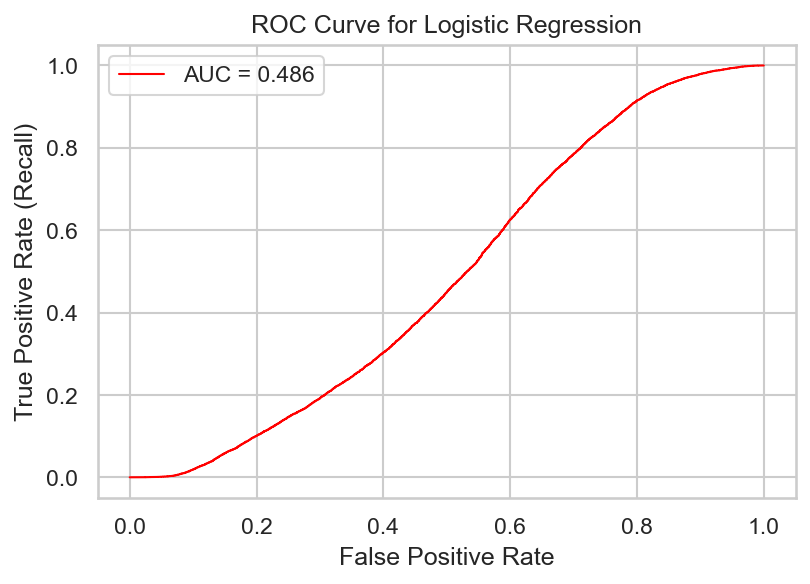

In [192]:
proba_lr = lr.predict_proba(X_test_lr)

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, proba_lr[:,1])
# get area under the curve
roc_auc_lr = auc(fpr_lr, tpr_lr)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr_lr, tpr_lr, lw=1, color='red', label=f'AUC = {roc_auc_lr:.3f}')
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

## Model 2: Decision Tree

In [193]:

feature_cols = ['danceability',
                    'energy',
                 #  'key',
                    'loudness',
                 #   'mode',
                    'speechiness',
                    'acousticness',
                    'instrumentalness',
                    'liveness',
                    'valence',
                    'tempo',
                    'duration_ms',
                   # 'time_signature',
                    'chorus_hit',
                    'sections',
                    'decade']

X_tree = df[feature_cols]
y_tree = df.target

from sklearn.model_selection import train_test_split
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.20)

### Tuning hyperparameters - max depth

In [194]:
from sklearn.tree import DecisionTreeClassifier

# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treeclass = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treeclass, X_tree, y_tree, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

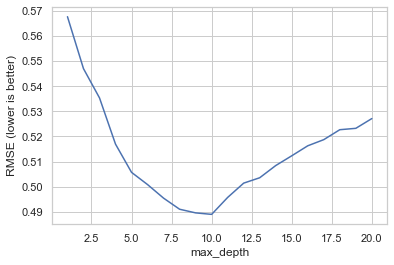

In [195]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [196]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=1)
classifier.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=10, random_state=1)

In [197]:
from sklearn import metrics
y_pred_tree = classifier.predict(X_test_tree)

print("Decision Tree Accuracy:", metrics.accuracy_score(y_test_tree, y_pred_tree))

Decision Tree Accuracy: 0.7686143984220908


In [198]:
target = ['flop','hit']
# Create a Graphviz file.
from sklearn.tree import export_graphviz
export_graphviz(classifier, out_file='tree_hits.dot', feature_names=feature_cols, class_names=target)
# At the command line, run this to convert to PNG:
#   dot -Tpng tree_hits.dot -o tree_hits.png

In [199]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':classifier.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
5,instrumentalness,0.413532
4,acousticness,0.130138
0,danceability,0.106754
9,duration_ms,0.072731
12,decade,0.058871
3,speechiness,0.058571
1,energy,0.058465
2,loudness,0.032711
7,valence,0.025280
8,tempo,0.018737


In [200]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_tree, y_pred_tree))
print(classification_report(y_test_tree, y_pred_tree))

[[2817 1283]
 [ 594 3418]]
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      4100
           1       0.73      0.85      0.78      4012

    accuracy                           0.77      8112
   macro avg       0.78      0.77      0.77      8112
weighted avg       0.78      0.77      0.77      8112



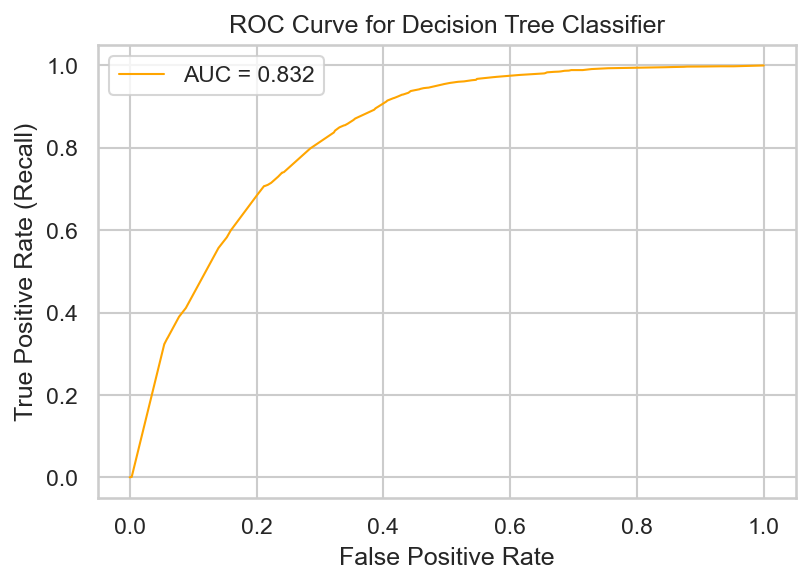

In [201]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib import pyplot as plt

tree = DecisionTreeClassifier(max_depth=7, random_state=1)
tree.fit(X_train_tree, y_train_tree)
tree_proba = tree.predict_proba(X_test_tree)

fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test_tree, tree_proba[:,1])
# get area under the curve
roc_auc_tree = auc(fpr_tree, tpr_tree)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr_tree, tpr_tree, lw=1, color='orange', label=f'AUC = {roc_auc_tree:.3f}')
plt.title('ROC Curve for Decision Tree Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

## Model 3: Random Forest Model

In [202]:
feature_cols_rfc = ['danceability',
                    'energy',
                    'key',
                    'loudness',
                    'mode',
                    'speechiness',
                    'acousticness',
                    'instrumentalness',
                    'liveness',
                    'valence',
                    'tempo',
                    'duration_ms',
                    'time_signature',
                    'chorus_hit',
                    'sections',
                    'decade']

X_rfc = df[feature_cols_rfc]
y_rfc = df.target

from sklearn.model_selection import train_test_split

X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(X_rfc, y_rfc, test_size=0.2, random_state=0)


In [203]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_rfc,y_train_rfc)

y_pred_rfc=clf.predict(X_test_rfc)

In [204]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Random Forest Classifier Accuracy:",metrics.accuracy_score(y_test_rfc, y_pred_rfc))

Random Forest Classifier Accuracy: 0.8085552268244576


#### Looking at Feature Importance

In [205]:

pd.DataFrame({'feature':feature_cols_rfc, 'importance':clf.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
7,instrumentalness,0.167224
6,acousticness,0.111011
0,danceability,0.103478
3,loudness,0.074847
11,duration_ms,0.072687
1,energy,0.071735
5,speechiness,0.070284
9,valence,0.067307
10,tempo,0.050654
8,liveness,0.047465


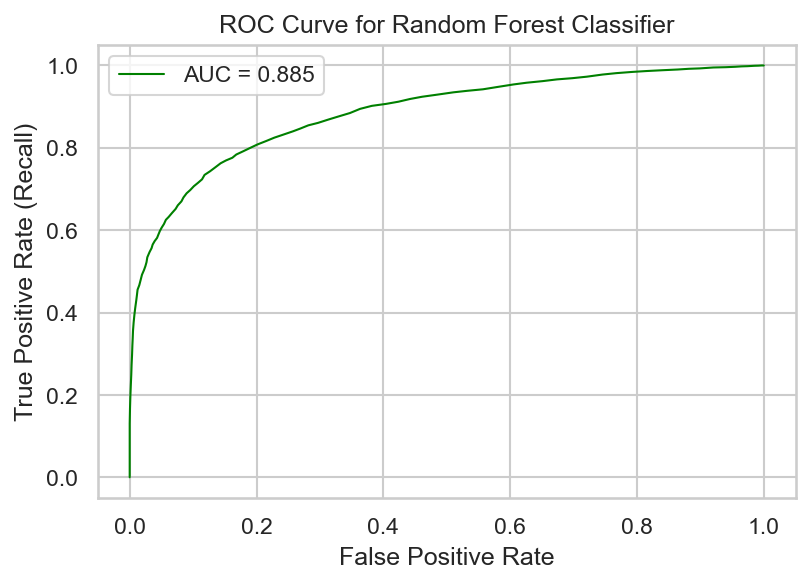

In [206]:
rfc_proba = clf.predict_proba(X_test_rfc)

from sklearn.metrics import roc_curve, auc
# get false and true positive rates
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test_rfc, rfc_proba[:,0], pos_label=0)
# get area under the curve
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr_rfc, tpr_rfc, lw=1, color='green', label=f'AUC = {roc_auc_rfc:.3f}')
plt.title('ROC Curve for Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

### Which model was the best? Comparing 3 Models

#### Comparing Accuracy

In [207]:
lr_accuracy = round(metrics.accuracy_score(y_test_lr, y_pred_lr),4)
tree_accuracy = round(metrics.accuracy_score(y_test_tree, y_pred_tree),4)
rfc_accuracy = round(metrics.accuracy_score(y_test_rfc, y_pred_rfc),4)

accuracy = [['Logistical Regression', lr_accuracy], ['Decision Tree Classifier', tree_accuracy], 
            ['Random Forest Classifier', rfc_accuracy]] 
  
# Create the pandas DataFrame 
df_accuracy = pd.DataFrame(accuracy, columns = ['Model', 'Accuracy']).sort_values("Accuracy", ascending=False)

df_accuracy

,Model,Accuracy
2,Random Forest Classifier,0.8086
1,Decision Tree Classifier,0.7686
0,Logistical Regression,0.5076


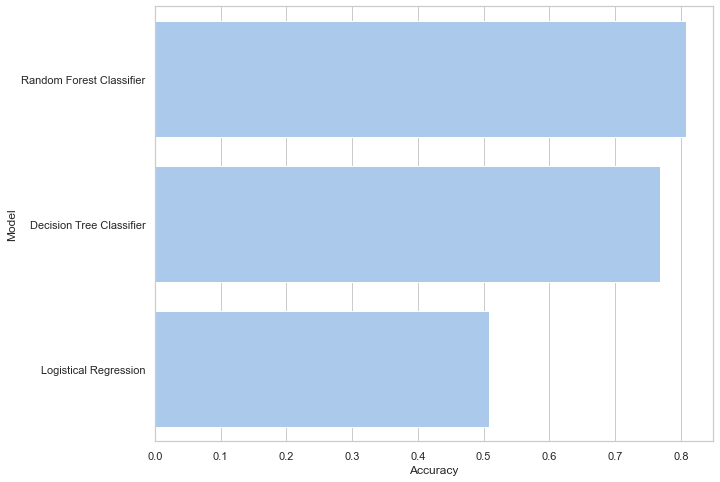

In [208]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Accuracy", y="Model", data=df_accuracy,
            label="Total", color="b")

#### Comparing ROC & AUC

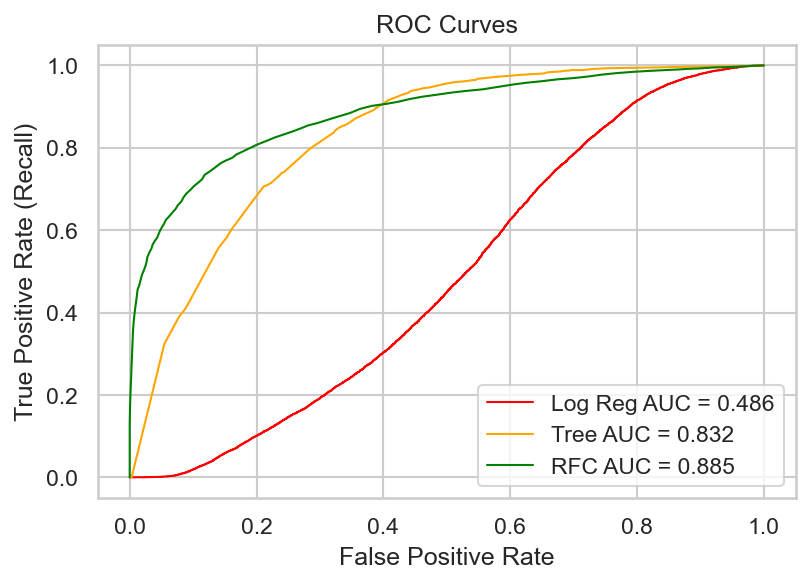

In [209]:
plt.figure(dpi=150)
plt.plot(fpr_lr, tpr_lr, lw=1, color='red', label=f'Log Reg AUC = {roc_auc_lr:.3f}')
plt.plot(fpr_tree, tpr_tree, lw=1, color='orange', label=f'Tree AUC = {roc_auc_tree:.3f}')
plt.plot(fpr_rfc, tpr_rfc, lw=1, color='green', label=f'RFC AUC = {roc_auc_rfc:.3f}')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()